In [64]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import cv2
import utils
import xml.etree.ElementTree as ET
from importlib import reload

In [113]:
reload(utils)

<module 'utils' from '/home/david/w251-project/utils.py'>

In [86]:
IMAGE = 'TrainData/images/strawimage1.jpg'
ANNOTATION = 'TrainData/annotations/strawimage1.xml'

Ripe RGB: (0, 255, 0), Unripe RGB: (0, 0, 255)


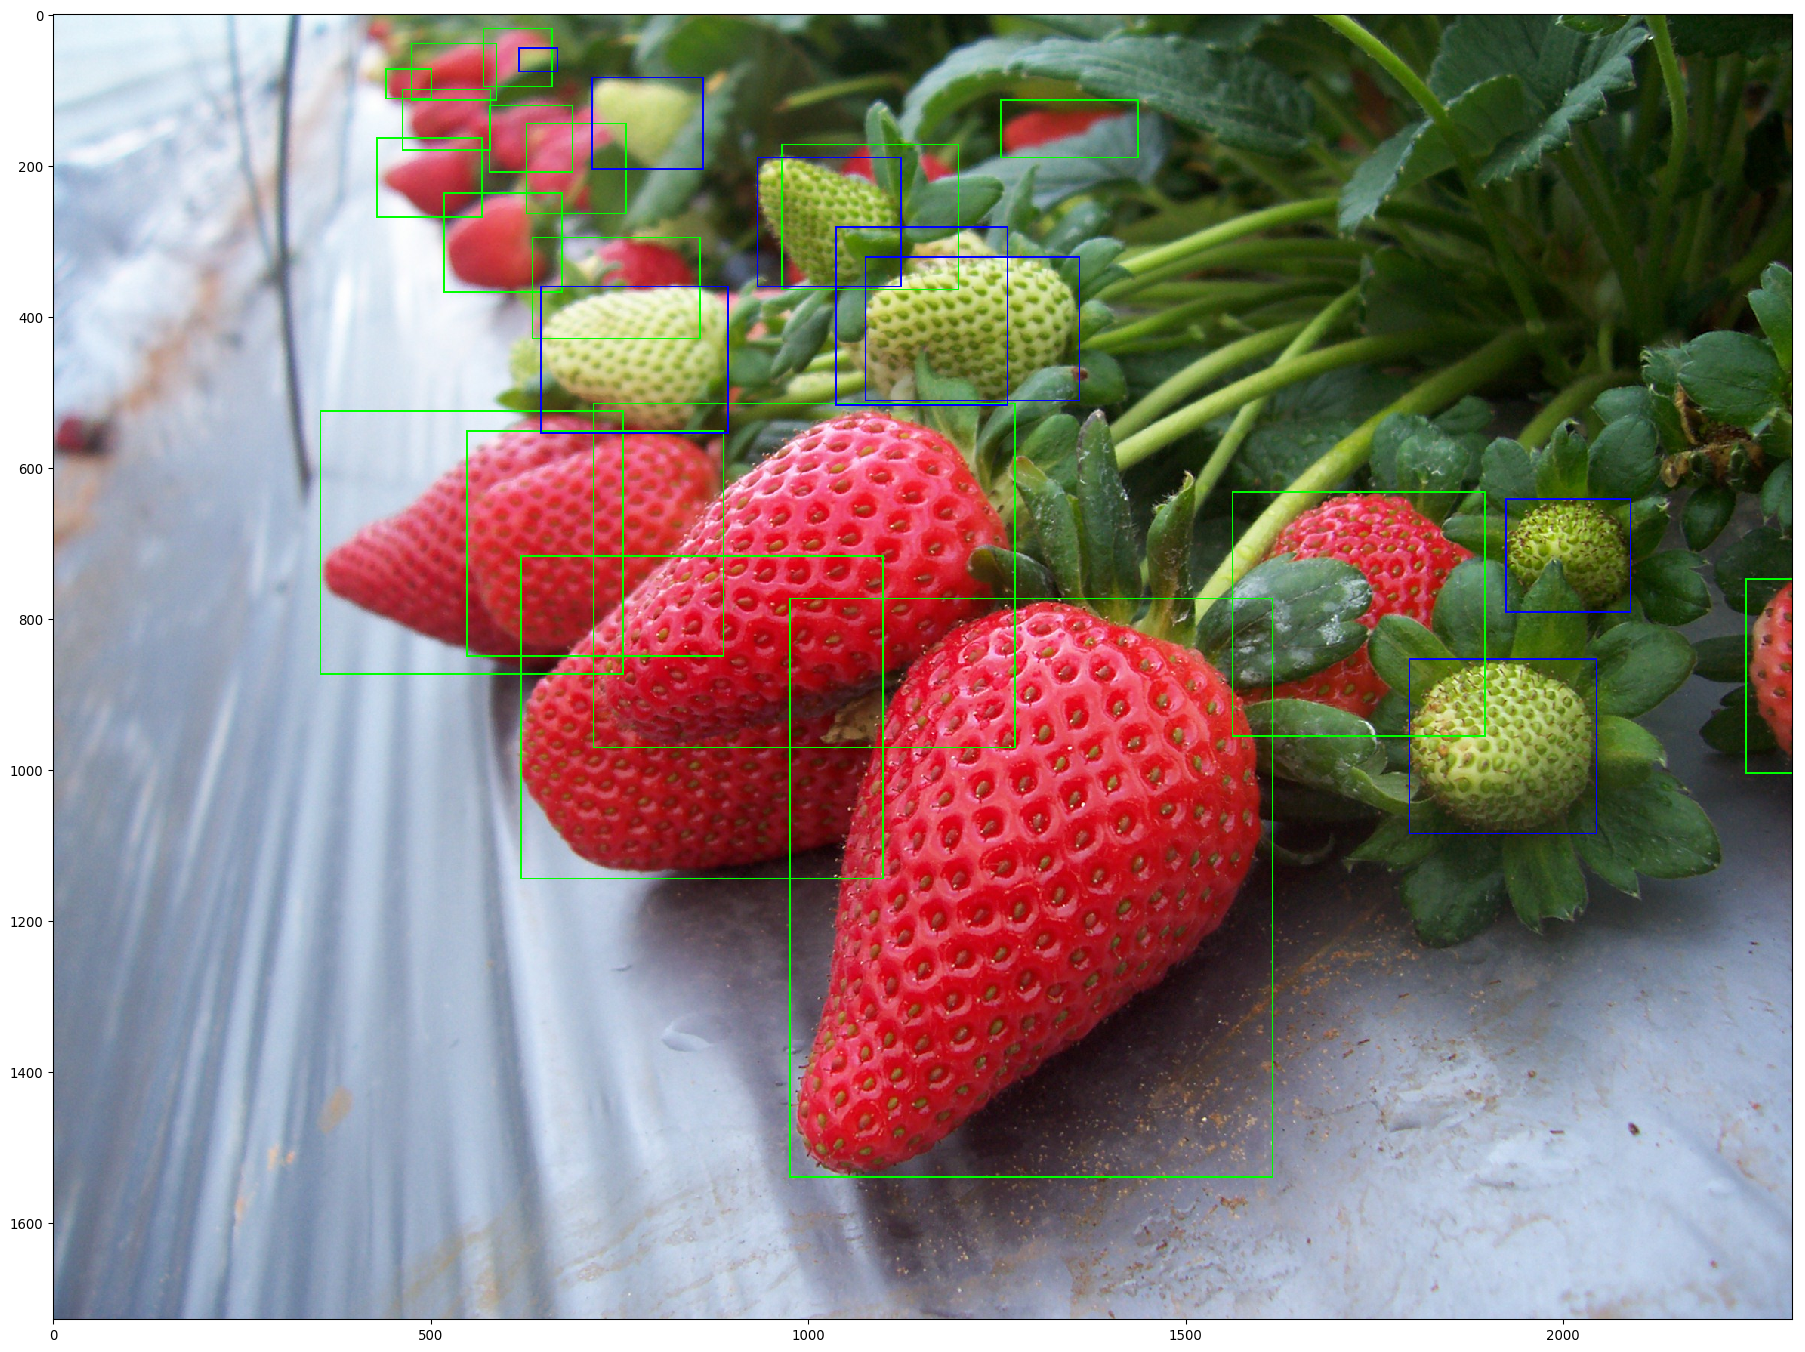

In [91]:
utils.show_annotated_image(image_path=IMAGE, annotation_path=ANNOTATION)

In [95]:
img = utils.read_image(IMAGE)
img_boxes = BoundingBoxesOnImage(utils.get_bounding_boxes(ANNOTATION), shape=img.shape)

seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        translate_px={"x": 40, "y": 60},
        scale=(0.5, 0.7)
    ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])

img_aug, img_boxes_aug = seq(image=img, bounding_boxes=img_boxes)

Ripe RGB: (0, 255, 0), Unripe RGB: (0, 0, 255)


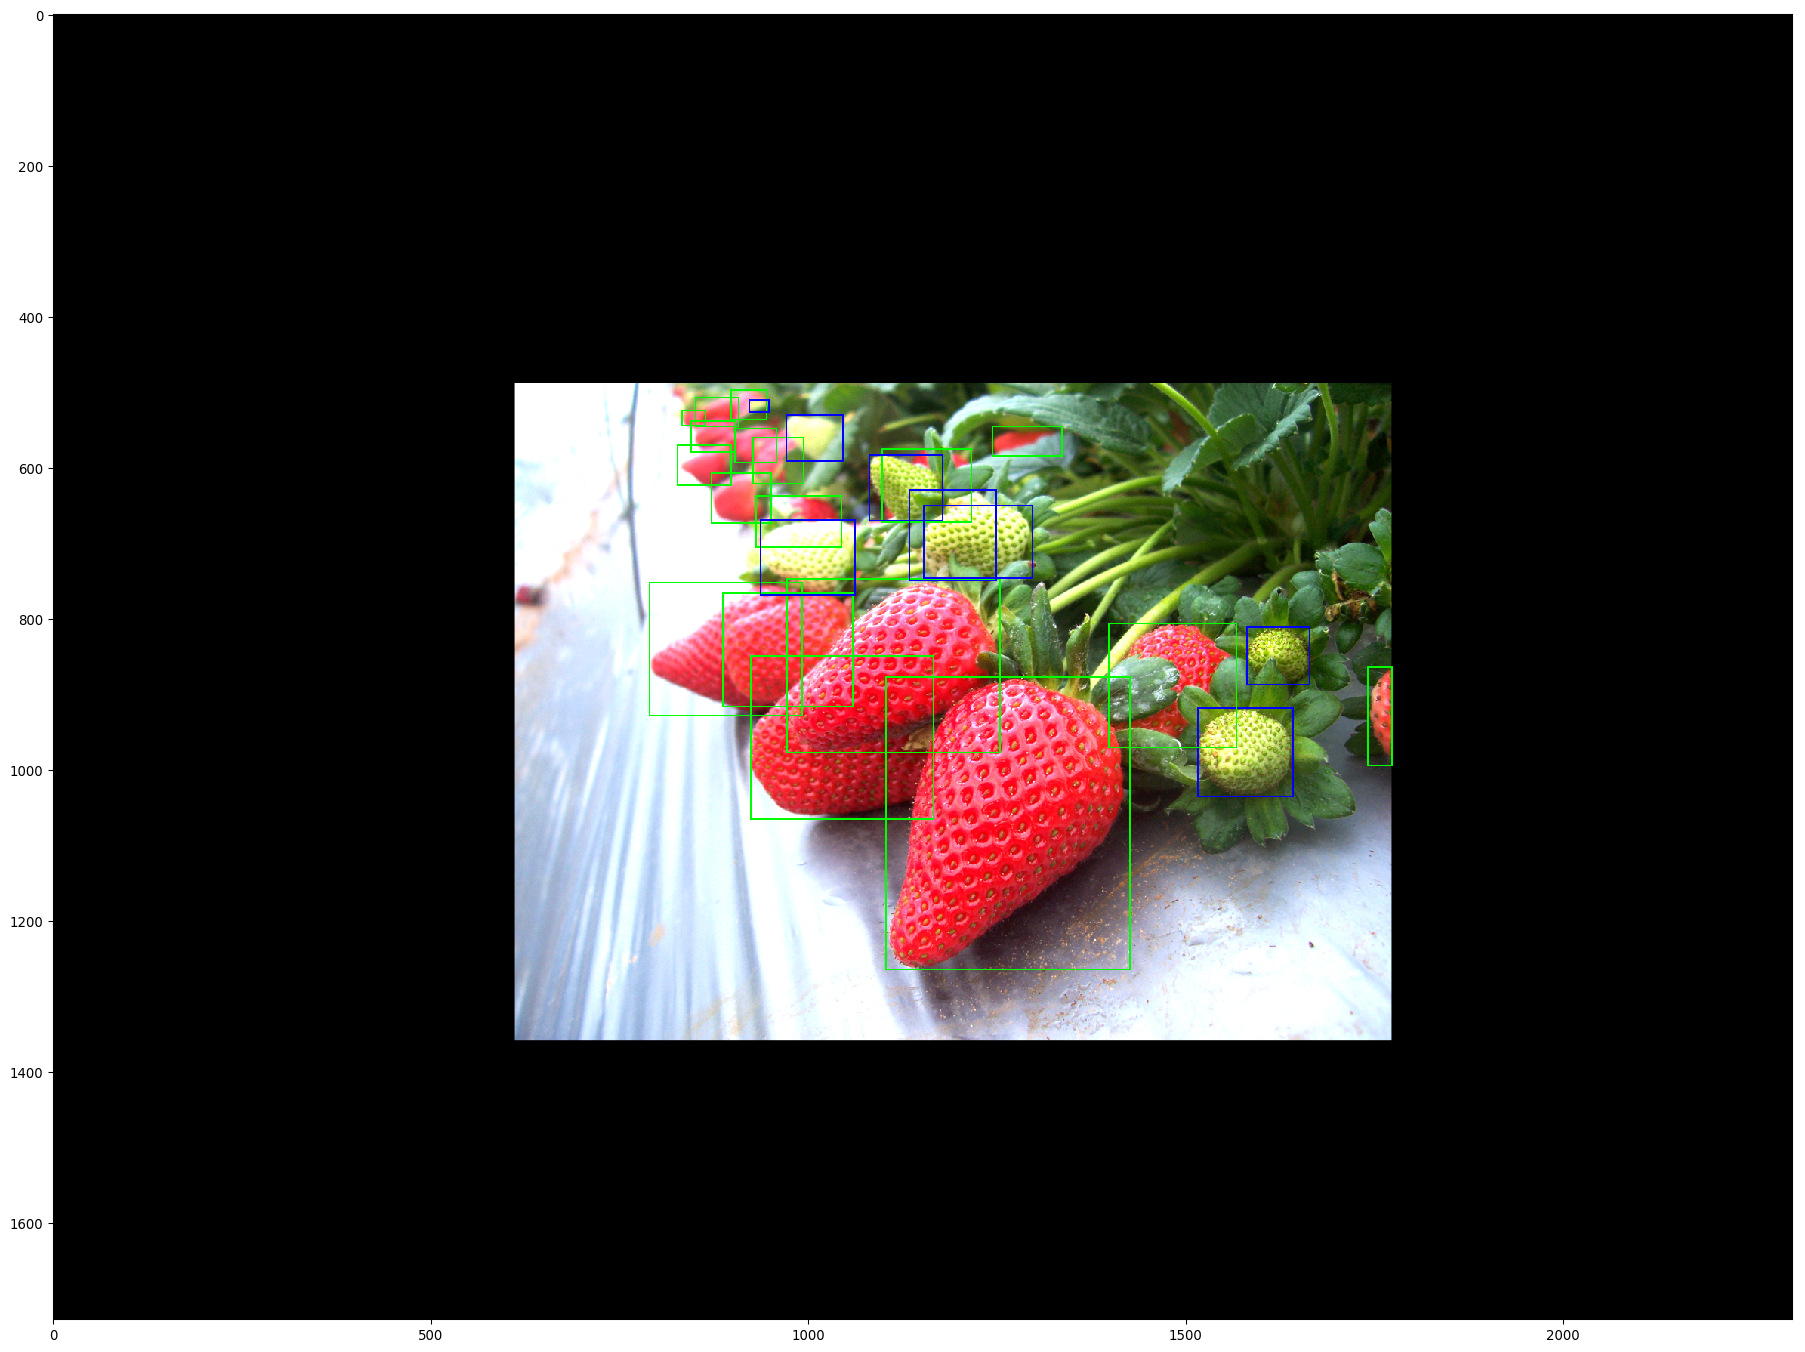

In [101]:
utils.show_annotated_image(image=img_aug, boxes=img_boxes_aug)

In [106]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image.
seq = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 5),
            [
                # Convert some images into their superpixel representation,
                # sample between 20 and 200 superpixels per image, but do
                # not replace all superpixels with their average, only
                # some of them (p_replace).
                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, 1.0),
                        n_segments=(20, 200)
                    )
                ),

                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                # Search in some images either for all edges or for
                # directed edges. These edges are then marked in a black
                # and white image and overlayed with the original image
                # using an alpha of 0 to 0.7.
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),

                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),

                # Either drop randomly 1 to 10% of all pixels (i.e. set
                # them to black) or drop them on an image with 2-5% percent
                # of the original size, leading to large dropped
                # rectangles.
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),

                # Invert each image's channel with 5% probability.
                # This sets each pixel value v to 255-v.
                iaa.Invert(0.05, per_channel=True), # invert color channels

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.5, 1.5), per_channel=0.5),

                # Improve or worsen the contrast of images.
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),

                # Convert each image to grayscale and then overlay the
                # result with the original with random alpha. I.e. remove
                # colors with varying strengths.
                iaa.Grayscale(alpha=(0.0, 1.0)),

                # In some images move pixels locally around (with random
                # strengths).
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

In [109]:
img_aug, img_boxes_aug = seq(image=img, bounding_boxes=img_boxes)

Ripe RGB: (0, 255, 0), Unripe RGB: (0, 0, 255)


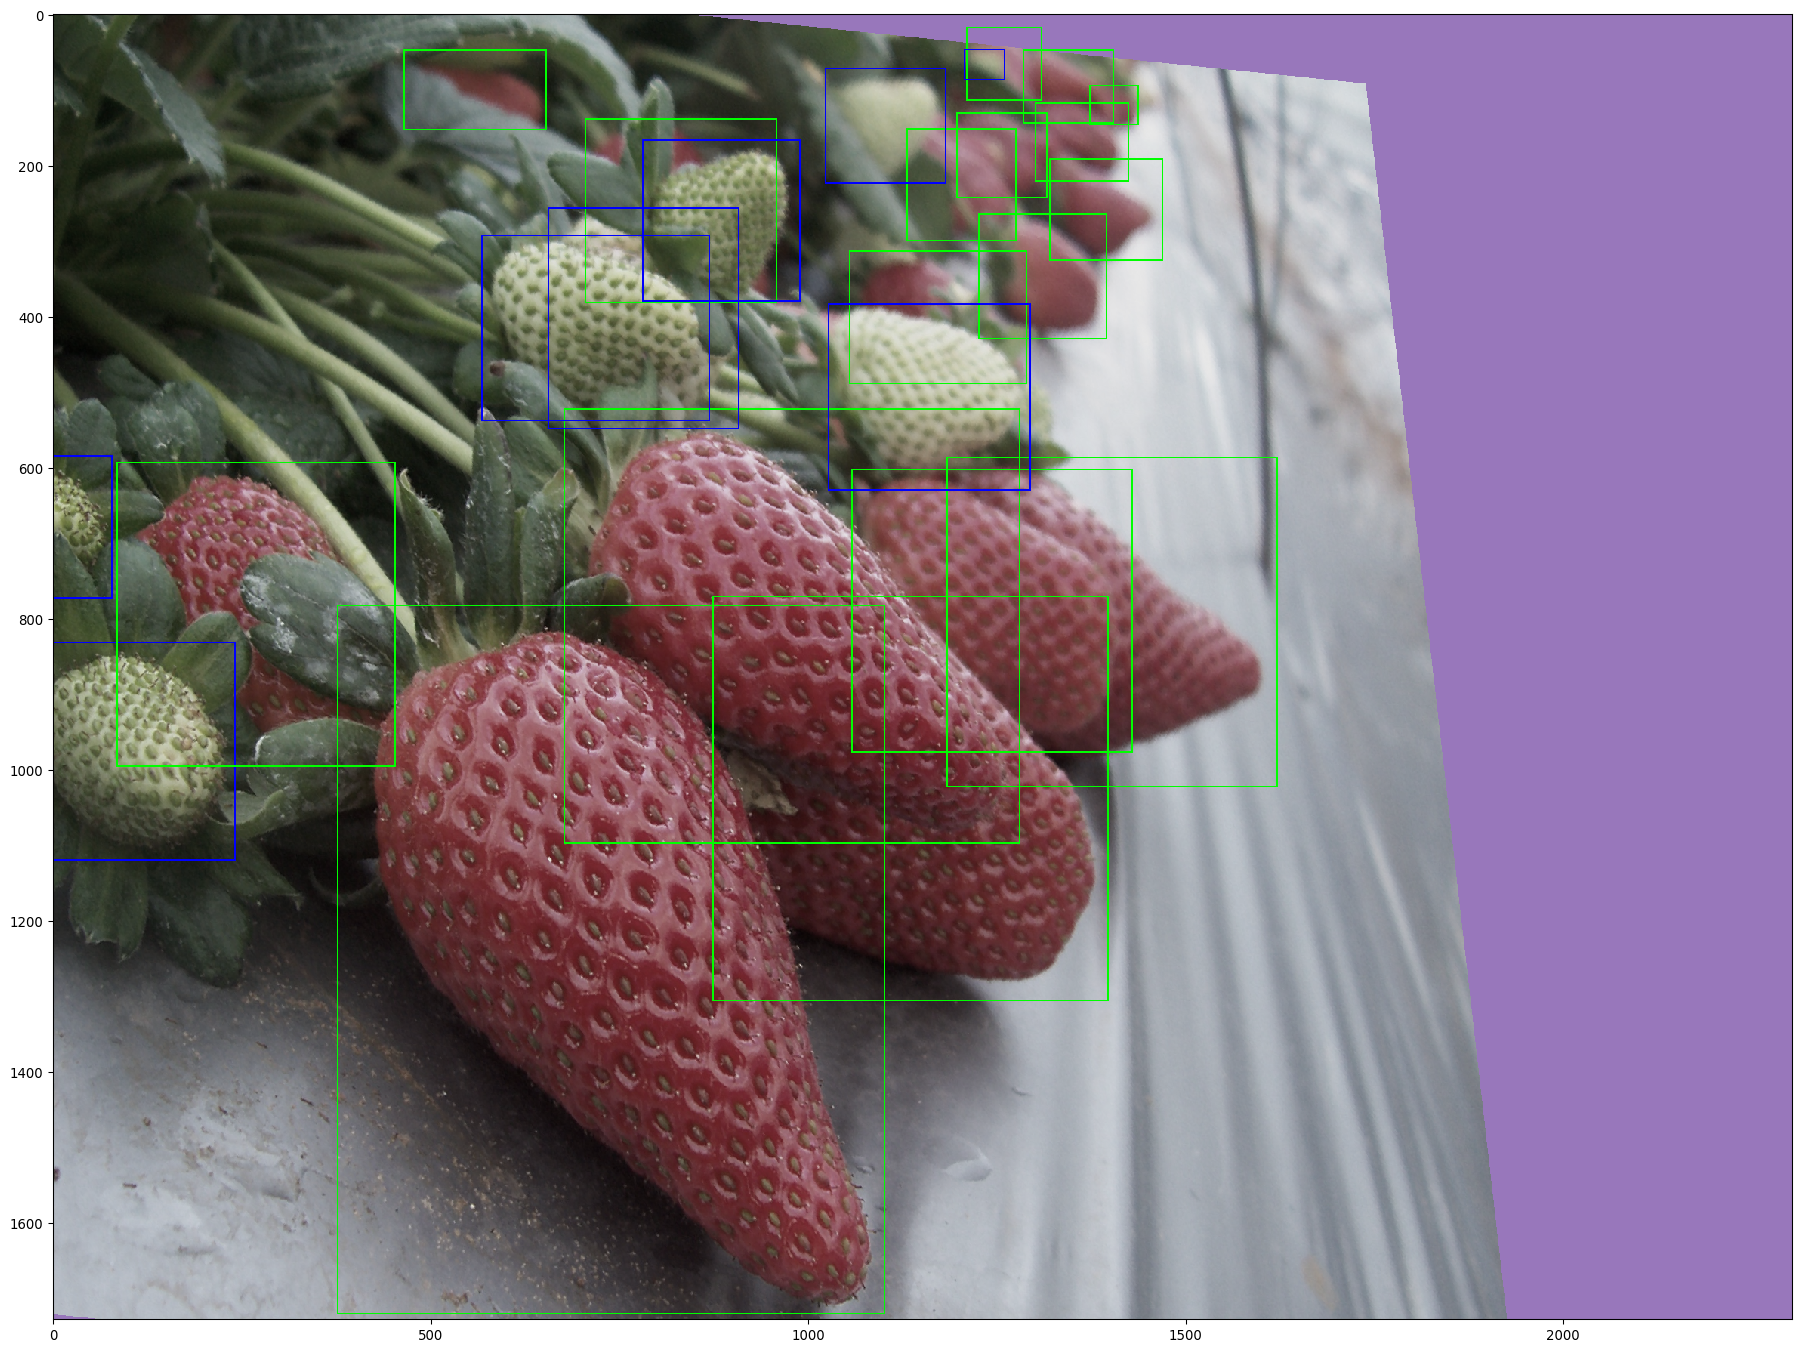

In [110]:
utils.show_annotated_image(image=img_aug, boxes=img_boxes_aug)

In [105]:
utils.write_image('test_augmented.jpg', img_aug)

In [115]:
print(utils.get_training_annotation('test_augmented.jpg', img_boxes_aug))

test.jpg,1373,95,1436,145,ripe_strawberry
test.jpg,1301,118,1423,220,ripe_strawberry
test.jpg,1210,18,1308,113,ripe_strawberry
test.jpg,1285,48,1403,143,ripe_strawberry
test.jpg,1197,131,1315,242,ripe_strawberry
test.jpg,1320,192,1468,325,ripe_strawberry
test.jpg,1131,152,1274,299,ripe_strawberry
test.jpg,1226,265,1394,429,ripe_strawberry
test.jpg,1055,314,1288,488,ripe_strawberry
test.jpg,705,139,957,381,ripe_strawberry
test.jpg,465,48,652,152,ripe_strawberry
test.jpg,1184,587,1620,1022,ripe_strawberry
test.jpg,1058,603,1428,976,ripe_strawberry
test.jpg,874,771,1396,1305,ripe_strawberry
test.jpg,677,523,1279,1097,ripe_strawberry
test.jpg,656,257,907,548,unripe_strawberry
test.jpg,1207,47,1259,86,unripe_strawberry
test.jpg,1023,72,1181,223,unripe_strawberry
test.jpg,1027,384,1293,629,unripe_strawberry
test.jpg,781,167,988,379,unripe_strawberry
test.jpg,568,293,868,537,unripe_strawberry
test.jpg,-102,585,77,772,unripe_strawberry
test.jpg,-299,685,-205,983,ripe_strawberry
test.jpg,-31,83

In [117]:
with open('test_augmented_annotate.txt', 'w') as f:
    f.write(utils.get_training_annotation('test.jpg', img_boxes_aug))